## **Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### **Loading Datasets(structured_data, behaviour_logs, audio_dataset)**

In [3]:
# Loading the three datasets from the available files
structured_dataset = pd.read_csv('structured_data.csv')
behaviour_dataset= pd.read_csv('behavior_logs.csv')
audio_dataset= pd.read_csv('audio_features.csv')

print('DataFrame 1 Head (structured_data):')
display(structured_dataset.head())

print('\nDataFrame 2 Head (behavior_logs):')
display(behaviour_dataset.head())

print('\nDataFrame 3 Head (audio_features):')
display(audio_dataset.head())

DataFrame 1 Head (structured_data):


,employee_id,tasks_completed,average_task_quality,projects_led,client_satisfaction_score,hours_worked,deadline_met_score,innovation_score,efficiency_score,performance_rating
0,1001,37,6,0,67,34,5,1,7,Low
1,1002,55,5,0,66,45,6,7,6,Low
2,1003,28,7,3,60,49,5,2,9,Low
3,1004,29,7,0,82,33,5,6,9,Medium
4,1005,26,7,2,88,49,5,2,5,Low



DataFrame 2 Head (behavior_logs):


,employee_id,meetings_attended,collaboration_score,punctuality_score,training_hours_completed,work_engagement_score,peer_interaction_score,initiative_score,task_followup_score,performance_rating
0,1001,10,9,6,17.8,7,6,1,6,Low
1,1002,8,6,6,8.3,9,7,9,5,Low
2,1003,15,7,9,6.4,8,9,8,6,Low
3,1004,17,9,7,12.5,5,6,3,5,Medium
4,1005,9,8,9,10.9,7,9,4,7,Low



DataFrame 3 Head (audio_features):


,employee_id,speech_sentiment_score,speech_energy_level,speech_clarity_score,tone_consistency_score,speaking_speed,pause_frequency,pitch_variation,volume_stability_score,performance_rating
0,1001,-0.73,6,9,2,147,5,1,2,Low
1,1002,-0.61,8,8,2,112,5,7,6,Low
2,1003,-0.12,5,9,2,115,2,5,6,Low
3,1004,-0.46,9,6,8,135,2,5,2,Medium
4,1005,-0.08,8,8,2,98,2,4,9,Low


In [4]:
structured_pre = structured_dataset.drop(columns=['performance_rating']).add_prefix('struct_').rename(columns={'struct_employee_id': 'employee_id'})
behav_pre = behaviour_dataset.drop(columns=['performance_rating']).add_prefix('behav_').rename(columns={'behav_employee_id': 'employee_id'})
audio_pre = audio_dataset.add_prefix('audio_').rename(columns={'audio_employee_id': 'employee_id','audio_performance_rating':'performance_rating'})

# Merge structured_pre and behav_pre first, then merge the result with audio_pre
dataset = pd.merge(structured_pre, behav_pre, on='employee_id')
dataset = pd.merge(dataset, audio_pre, on='employee_id')

In [5]:
dataset

,employee_id,struct_tasks_completed,struct_average_task_quality,struct_projects_led,struct_client_satisfaction_score,struct_hours_worked,struct_deadline_met_score,struct_innovation_score,struct_efficiency_score,behav_meetings_attended,...,behav_task_followup_score,audio_speech_sentiment_score,audio_speech_energy_level,audio_speech_clarity_score,audio_tone_consistency_score,audio_speaking_speed,audio_pause_frequency,audio_pitch_variation,audio_volume_stability_score,performance_rating
0,1001,37,6,0,67,34,5,1,7,10,...,6,-0.73,6,9,2,147,5,1,2,Low
1,1002,55,5,0,66,45,6,7,6,8,...,5,-0.61,8,8,2,112,5,7,6,Low
2,1003,28,7,3,60,49,5,2,9,15,...,6,-0.12,5,9,2,115,2,5,6,Low
3,1004,29,7,0,82,33,5,6,9,17,...,5,-0.46,9,6,8,135,2,5,2,Medium
4,1005,26,7,2,88,49,5,2,5,9,...,7,-0.08,8,8,2,98,2,4,9,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,5996,46,7,3,53,34,7,7,7,8,...,5,0.66,8,5,5,155,3,9,9,High
4996,5997,24,5,1,58,31,7,8,9,14,...,5,1.00,5,5,6,121,8,5,1,Low
4997,5998,24,9,3,86,38,7,4,6,14,...,7,0.94,9,7,2,152,9,8,2,High
4998,5999,35,8,0,86,38,6,1,7,9,...,5,-0.69,5,5,2,116,1,5,3,Medium


In [6]:
dataset.shape

(5000, 26)

In [7]:
feature_dataset = dataset.copy()

In [8]:
feature_dataset.shape

(5000, 26)

In [9]:
feature_dataset['productivity_index'] = (feature_dataset['struct_tasks_completed'] * feature_dataset['struct_efficiency_score']) / feature_dataset['struct_hours_worked']

feature_dataset['quality_consistency'] = (feature_dataset['struct_average_task_quality'] * feature_dataset['behav_task_followup_score']) / 10

feature_dataset['communication_quality'] = (feature_dataset['audio_speech_clarity_score'] * feature_dataset['audio_tone_consistency_score']) / 10

feature_dataset['engagement_communication'] = (feature_dataset['behav_work_engagement_score'] * feature_dataset['audio_speech_energy_level']) / 10



In [10]:
feature_dataset['leadership_score'] = (feature_dataset['struct_projects_led'] * feature_dataset['behav_initiative_score']) / 10

feature_dataset['collaborative_leadership'] = (feature_dataset['behav_collaboration_score'] * feature_dataset['behav_peer_interaction_score']) / 10

feature_dataset['client_interaction_quality'] = feature_dataset['struct_client_satisfaction_score'] * feature_dataset['audio_speech_sentiment_score']

feature_dataset['reliable_delivery'] = (feature_dataset['struct_deadline_met_score'] * feature_dataset['behav_punctuality_score']) / 10

feature_dataset['sentiment_engagement_alignment'] = ((feature_dataset['audio_speech_sentiment_score'] + 1) * feature_dataset['behav_work_engagement_score']) / 2

feature_dataset['energy_initiative'] = (feature_dataset['audio_speech_energy_level'] * feature_dataset['behav_initiative_score']) / 10

In [11]:
feature_dataset['struct_feature_mean'] = feature_dataset.filter(like='struct_').mean(axis=1)
feature_dataset['struct_feature_std'] = feature_dataset.filter(like='struct_').std(axis=1)

feature_dataset['behav_feature_mean'] = feature_dataset.filter(like='behav_').mean(axis=1)
feature_dataset['audio_feature_mean'] = feature_dataset.filter(like='audio_').mean(axis=1)

feature_dataset['cross_modal_variance'] = feature_dataset[
    ['struct_feature_mean', 'behav_feature_mean', 'audio_feature_mean']
].var(axis=1)

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   employee_id                       5000 non-null   int64  
 1   struct_tasks_completed            5000 non-null   int64  
 2   struct_average_task_quality       5000 non-null   int64  
 3   struct_projects_led               5000 non-null   int64  
 4   struct_client_satisfaction_score  5000 non-null   int64  
 5   struct_hours_worked               5000 non-null   int64  
 6   struct_deadline_met_score         5000 non-null   int64  
 7   struct_innovation_score           5000 non-null   int64  
 8   struct_efficiency_score           5000 non-null   int64  
 9   behav_meetings_attended           5000 non-null   int64  
 10  behav_collaboration_score         5000 non-null   int64  
 11  behav_punctuality_score           5000 non-null   int64  
 12  behav_

In [13]:
correlation_matrix = dataset.corr(numeric_only=True)
display(correlation_matrix)

,employee_id,struct_tasks_completed,struct_average_task_quality,struct_projects_led,struct_client_satisfaction_score,struct_hours_worked,struct_deadline_met_score,struct_innovation_score,struct_efficiency_score,behav_meetings_attended,...,behav_initiative_score,behav_task_followup_score,audio_speech_sentiment_score,audio_speech_energy_level,audio_speech_clarity_score,audio_tone_consistency_score,audio_speaking_speed,audio_pause_frequency,audio_pitch_variation,audio_volume_stability_score
employee_id,1.000000,0.022585,0.015140,-0.019701,-0.002924,-0.004879,-0.012904,0.014518,0.000846,0.010585,...,0.021693,0.003269,0.002214,-0.005022,0.004915,0.014123,0.015774,0.010522,0.004651,-0.009008
struct_tasks_completed,0.022585,1.000000,0.003796,-0.020647,-0.003865,-0.003551,-0.001900,0.006352,0.003112,-0.016148,...,0.004058,0.015988,-0.005801,-0.017549,-0.018228,0.020643,-0.008116,-0.022349,-0.035777,0.024778
struct_average_task_quality,0.015140,0.003796,1.000000,0.018717,0.020767,-0.000630,0.004866,-0.026495,0.003846,0.010905,...,0.009125,0.018680,0.030950,0.023196,0.008922,-0.010948,0.003590,0.000875,0.008809,0.001559
struct_projects_led,-0.019701,-0.020647,0.018717,1.000000,-0.009021,0.007056,-0.002871,0.000723,-0.029603,0.004551,...,0.009511,0.000766,-0.015152,0.001956,0.037815,0.000220,0.013195,-0.012381,0.016647,0.009871
struct_client_satisfaction_score,-0.002924,-0.003865,0.020767,-0.009021,1.000000,0.000799,0.013760,0.013782,0.015707,-0.034029,...,-0.012815,0.015547,0.001067,0.014872,-0.007503,0.013592,-0.009363,0.000889,0.021976,0.027838
struct_hours_worked,-0.004879,-0.003551,-0.000630,0.007056,0.000799,1.000000,-0.010801,0.009467,-0.001132,0.002293,...,0.011103,0.003885,-0.021774,0.001576,-0.021402,0.009821,-0.005608,0.015108,-0.009568,-0.003547
struct_deadline_met_score,-0.012904,-0.001900,0.004866,-0.002871,0.013760,-0.010801,1.000000,-0.000611,-0.013775,-0.022471,...,0.007396,0.006565,0.017805,0.009919,0.013348,0.023099,-0.005503,-0.020527,0.002797,-0.042663
struct_innovation_score,0.014518,0.006352,-0.026495,0.000723,0.013782,0.009467,-0.000611,1.000000,0.008182,-0.015927,...,-0.000489,-0.003057,-0.002024,-0.011938,-0.012086,0.002431,0.015580,-0.020007,0.011541,-0.002092
struct_efficiency_score,0.000846,0.003112,0.003846,-0.029603,0.015707,-0.001132,-0.013775,0.008182,1.000000,-0.013776,...,-0.002235,-0.031619,0.023834,0.015138,-0.003162,-0.001483,-0.022443,0.010644,-0.008928,0.003251
behav_meetings_attended,0.010585,-0.016148,0.010905,0.004551,-0.034029,0.002293,-0.022471,-0.015927,-0.013776,1.000000,...,-0.019097,0.002851,-0.016634,-0.004981,0.003770,-0.005233,0.015226,-0.002783,0.000423,0.000958


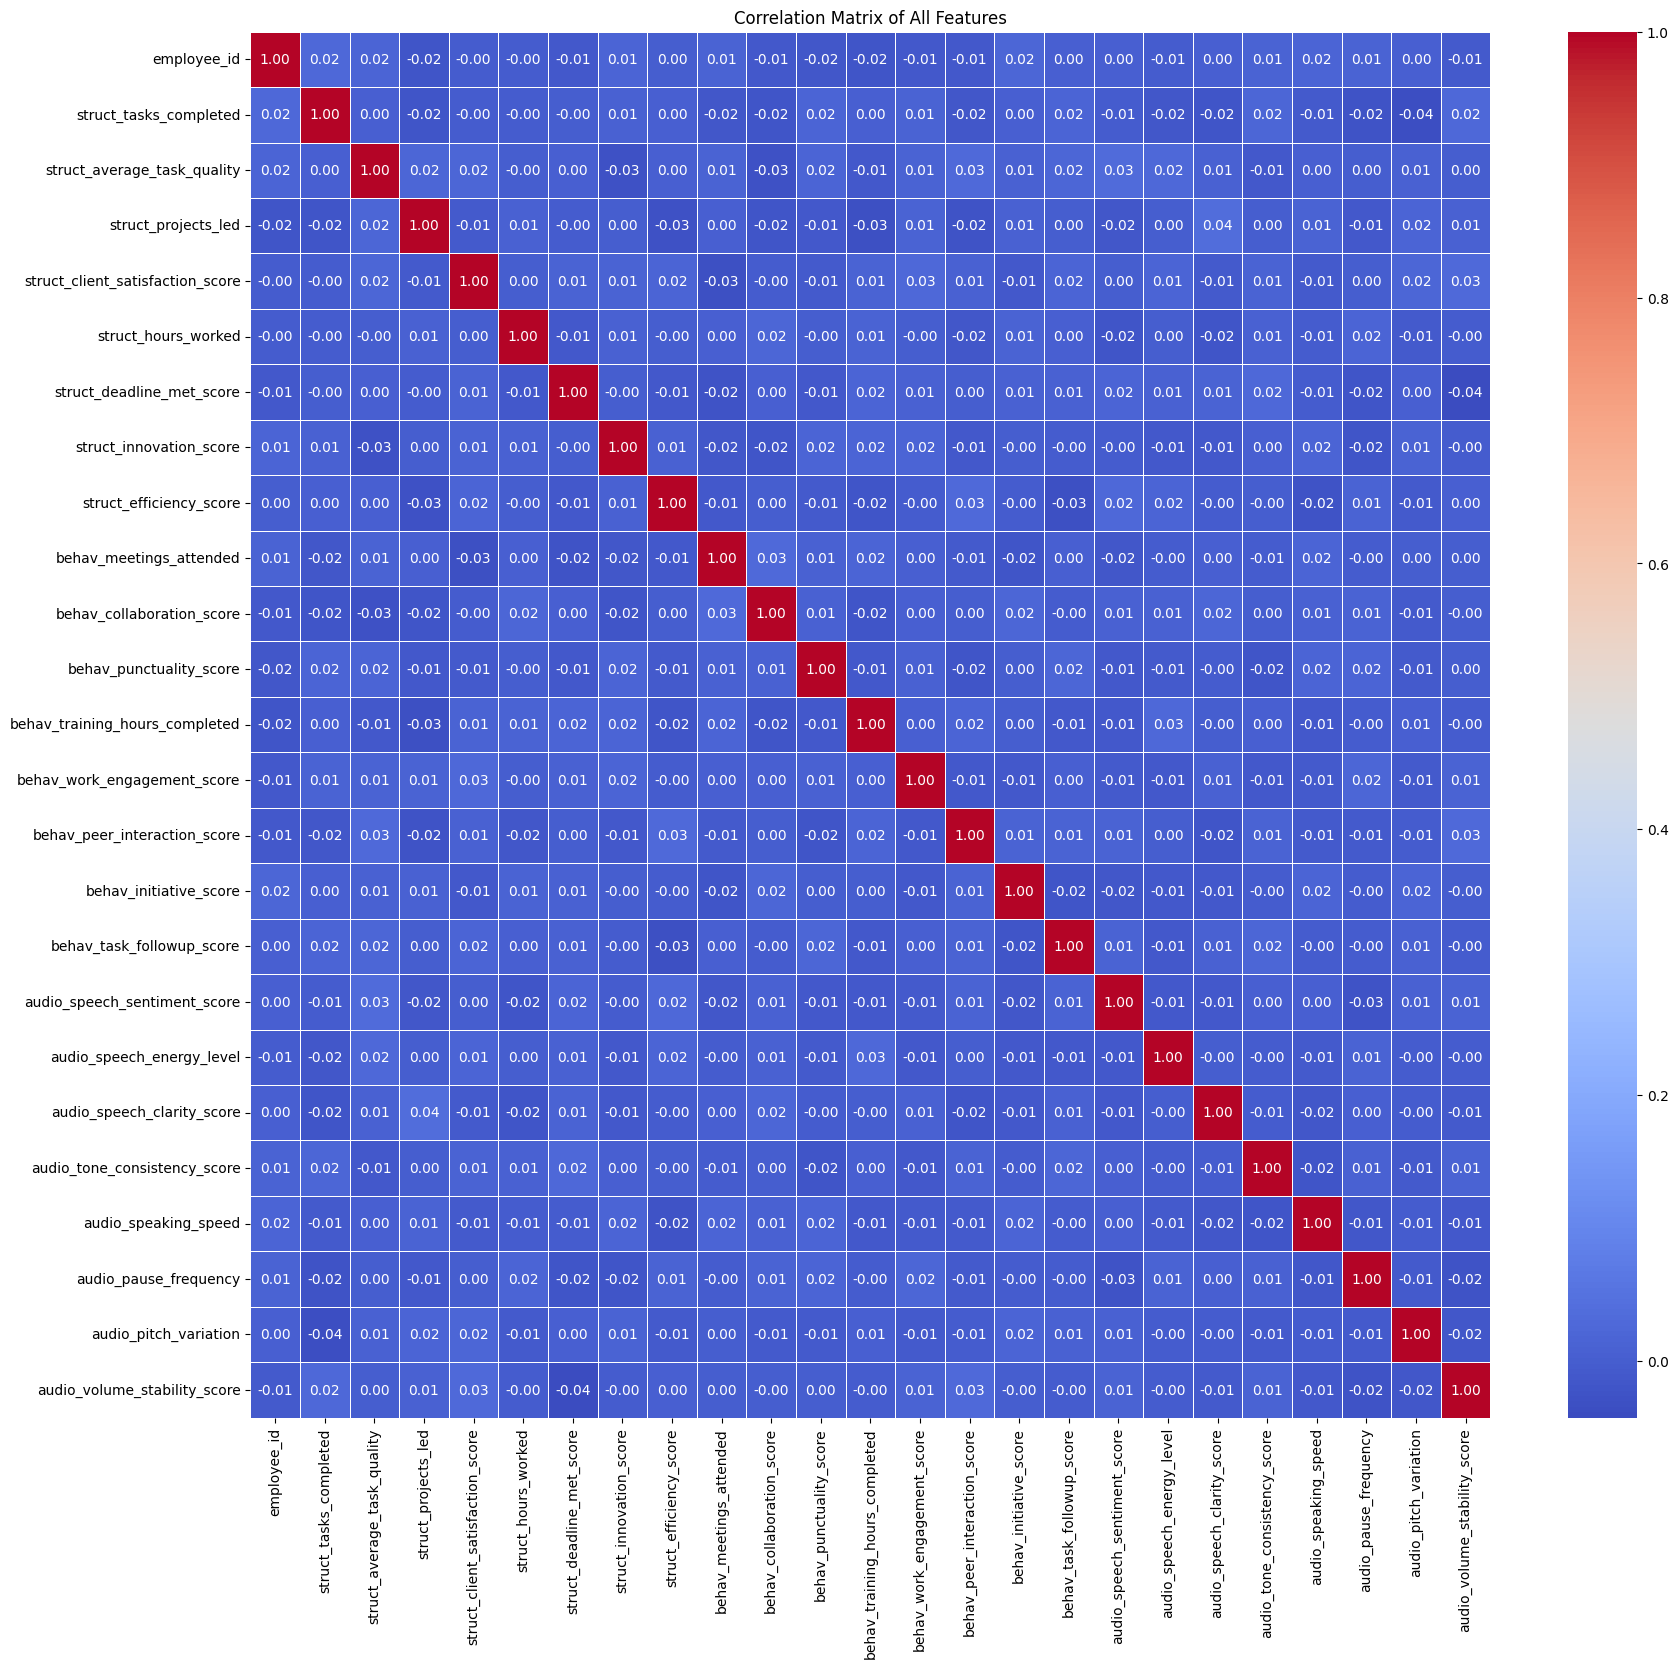

In [14]:
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of All Features')
plt.savefig('correlation_matrix.png')
plt.show()


In [15]:
high_corr_pairs = []
# Iterate through the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)): # Start from i+1 to avoid self-correlation and duplicates
        feature1 = correlation_matrix.columns[i]
        feature2 = correlation_matrix.columns[j]
        correlation_value = correlation_matrix.iloc[i, j]

        # Check if the absolute correlation is greater than 0.85
        if abs(correlation_value) > 0.85:
            high_corr_pairs.append((feature1, feature2, correlation_value))

# Display the highly correlated pairs
if high_corr_pairs:
    print("Highly correlated feature pairs (|correlation| > 0.85):")
    for f1, f2, corr_val in high_corr_pairs:
        print(f"- {f1} and {f2}: {corr_val:.2f}")
else:
    print("No feature pairs found with absolute correlation greater than 0.85.")

No feature pairs found with absolute correlation greater than 0.85.


Features with an absolute correlation greater than 0.85 are considered highly correlated, suggesting that one of the pair might be redundant as they capture similar information.

In [16]:
numerical_features = dataset.select_dtypes(include=np.number).columns.tolist()
features_for_vif = [col for col in numerical_features if col not in ['employee_id', 'performance_rating_encoded']]

X = dataset[features_for_vif]

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF scores for numerical features (excluding employee_id and performance_rating_encoded):")
print(vif_data.sort_values(by='VIF', ascending=False))

VIF scores for numerical features (excluding employee_id and performance_rating_encoded):
                             feature        VIF
4                struct_hours_worked  42.584115
10           behav_punctuality_score  40.850421
3   struct_client_satisfaction_score  25.811745
20              audio_speaking_speed  25.403952
12       behav_work_engagement_score  24.443014
9          behav_collaboration_score  24.200875
18        audio_speech_clarity_score  24.148519
1        struct_average_task_quality  24.077559
7            struct_efficiency_score  24.046827
5          struct_deadline_met_score  24.018538
13      behav_peer_interaction_score  23.845066
15         behav_task_followup_score  23.835079
0             struct_tasks_completed  12.241247
17         audio_speech_energy_level   9.895785
11    behav_training_hours_completed   9.076117
8            behav_meetings_attended   8.471634
19      audio_tone_consistency_score   4.708767
14            behav_initiative_score   4.67767

In [17]:
high_vif = vif_data[vif_data['VIF'] > 10]
print(high_vif)

                             feature        VIF
0             struct_tasks_completed  12.241247
1        struct_average_task_quality  24.077559
3   struct_client_satisfaction_score  25.811745
4                struct_hours_worked  42.584115
5          struct_deadline_met_score  24.018538
7            struct_efficiency_score  24.046827
9          behav_collaboration_score  24.200875
10           behav_punctuality_score  40.850421
12       behav_work_engagement_score  24.443014
13      behav_peer_interaction_score  23.845066
15         behav_task_followup_score  23.835079
18        audio_speech_clarity_score  24.148519
20              audio_speaking_speed  25.403952


The following features have high VIFs and are highly correlated with other features, so they will be removed to reduce redundancy:

Structured features: struct_hours_worked, struct_efficiency_score, struct_deadline_met_score, struct_client_satisfaction_score → correlated with struct_tasks_completed and struct_average_task_quality.

Behavioral features: behav_collaboration_score, behav_peer_interaction_score, behav_task_followup_score, behav_punctuality_score → correlated with behav_work_engagement_score and behav_initiative_score.

Audio features: audio_speaking_speed, audio_speech_clarity_score → correlated with audio_speech_sentiment_score.

In [18]:
features_to_remove = [
    'struct_hours_worked', 'struct_efficiency_score', 'struct_deadline_met_score', 'struct_client_satisfaction_score',
    'behav_collaboration_score', 'behav_peer_interaction_score', 'behav_task_followup_score', 'behav_punctuality_score',
    'audio_speaking_speed', 'audio_speech_clarity_score'
]

# Drop the features from the dataset
reduced_feature = dataset.drop(columns=features_to_remove)

# Check the remaining columns
print(reduced_feature.columns)

Index(['employee_id', 'struct_tasks_completed', 'struct_average_task_quality',
       'struct_projects_led', 'struct_innovation_score',
       'behav_meetings_attended', 'behav_training_hours_completed',
       'behav_work_engagement_score', 'behav_initiative_score',
       'audio_speech_sentiment_score', 'audio_speech_energy_level',
       'audio_tone_consistency_score', 'audio_pause_frequency',
       'audio_pitch_variation', 'audio_volume_stability_score',
       'performance_rating'],
      dtype='object')


In [19]:
dataset.head()

,employee_id,struct_tasks_completed,struct_average_task_quality,struct_projects_led,struct_client_satisfaction_score,struct_hours_worked,struct_deadline_met_score,struct_innovation_score,struct_efficiency_score,behav_meetings_attended,...,behav_task_followup_score,audio_speech_sentiment_score,audio_speech_energy_level,audio_speech_clarity_score,audio_tone_consistency_score,audio_speaking_speed,audio_pause_frequency,audio_pitch_variation,audio_volume_stability_score,performance_rating
0,1001,37,6,0,67,34,5,1,7,10,...,6,-0.73,6,9,2,147,5,1,2,Low
1,1002,55,5,0,66,45,6,7,6,8,...,5,-0.61,8,8,2,112,5,7,6,Low
2,1003,28,7,3,60,49,5,2,9,15,...,6,-0.12,5,9,2,115,2,5,6,Low
3,1004,29,7,0,82,33,5,6,9,17,...,5,-0.46,9,6,8,135,2,5,2,Medium
4,1005,26,7,2,88,49,5,2,5,9,...,7,-0.08,8,8,2,98,2,4,9,Low


In [20]:
rating_map = {'Low': 0, 'Medium': 1, 'High': 2}

# Apply to your dataframe
dataset['performance_rating_encoded'] = dataset['performance_rating'].map(rating_map)

In [21]:
X = dataset.iloc[:, 1 :-2].values
y = dataset.iloc[:, -1].values

In [22]:
X

array([[37.,  6.,  0., ...,  5.,  1.,  2.],
       [55.,  5.,  0., ...,  5.,  7.,  6.],
       [28.,  7.,  3., ...,  2.,  5.,  6.],
       ...,
       [24.,  9.,  3., ...,  9.,  8.,  2.],
       [35.,  8.,  0., ...,  1.,  5.,  3.],
       [50.,  5.,  0., ...,  0.,  7.,  3.]])

In [23]:
y

array([0, 0, 0, ..., 2, 1, 0])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [25]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [26]:
classifier = RandomForestClassifier(n_estimators = 100, random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# 1. Make predictions on the training set
# Rationale: This helps to evaluate how well the model has learned the training data.
y_pred_train = classifier.predict(X_train)

# 2. Make predictions on the test set
# Rationale: This is the primary evaluation of the model's generalization ability on unseen data.
y_pred_test = classifier.predict(X_test)

print("Predictions on training set (first 5):", y_pred_train[:5])
print("Predictions on test set (first 5):", y_pred_test[:5])

Predictions on training set (first 5): [0 0 1 0 0]
Predictions on test set (first 5): [0 0 2 0 1]


Training Accuracy: 1.0000
Test Accuracy: 0.7540


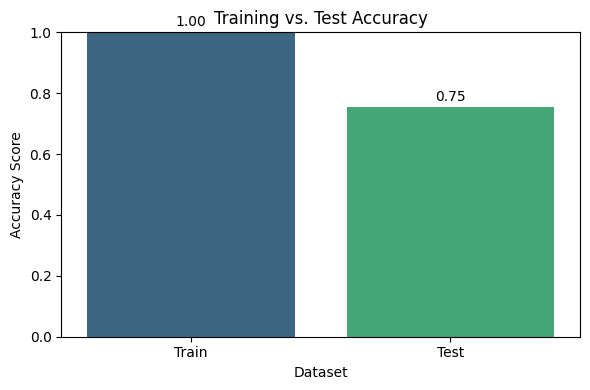

In [28]:
# 1. Bar Chart: Training vs. Test Accuracy
# Rationale: This plot provides a quick visual comparison of model performance on seen vs. unseen data.
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

accuracy_scores = {'Dataset': ['Train', 'Test'], 'Accuracy': [train_accuracy, test_accuracy]}
accuracy_df = pd.DataFrame(accuracy_scores)

plt.figure(figsize=(6, 4))
sns.barplot(x='Dataset', y='Accuracy', data=accuracy_df, palette='viridis', hue='Dataset', legend=False)
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.title('Training vs. Test Accuracy')
plt.ylabel('Accuracy Score')

 # Add text labels for accuracy values
for index, row in accuracy_df.iterrows():
  plt.text(index, row['Accuracy'] + 0.02, f"{row['Accuracy']:.2f}", color='black', ha="center")

plt.tight_layout()
plt.savefig('train_test_accuracy_bar_chart.png')
plt.show()




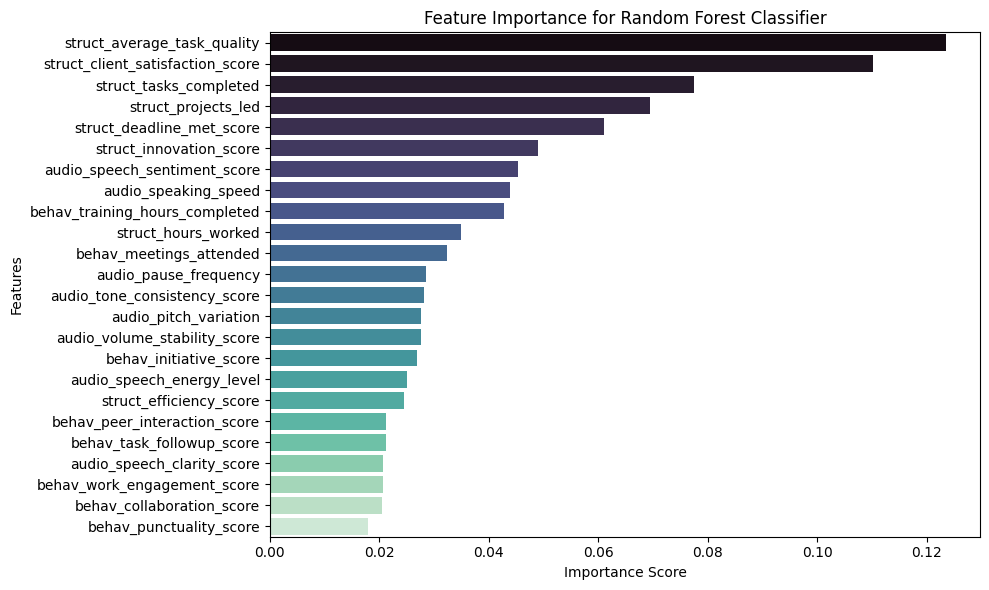

In [29]:
# 2. Feature Importance Plot
# Rationale: Understanding feature importance helps in identifying key drivers
# for employee performance and provides insights for business decisions.

# Get feature importances from the trained classifier
importances = classifier.feature_importances_

# Get feature names (excluding employee_id and performance_rating from the original dataset)
# We need to ensure the order of feature names matches the order of features in X_train
# The original features DataFrame was created in cell hY_Iba5JnQJm, and its columns are relevant.
# X = dataset.iloc[:, 1 :-2].values; so we need to get columns from original dataset
# dropping 'employee_id', 'performance_rating', and 'performance_rating_encoded'

# Re-create feature names list based on how X was constructed
original_feature_cols = dataset.drop(columns=['employee_id', 'performance_rating', 'performance_rating_encoded']).columns

feat_importances = pd.Series(importances, index=original_feature_cols)
feat_importances = feat_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances, y=feat_importances.index, palette='mako', hue=feat_importances.index, legend=False)
plt.title('Feature Importance for Random Forest Classifier')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('feature_importance_plot.png')
plt.show()

In [30]:
importance_threshold = 0.025  # can adjust based on distribution
selected_feature_names = feat_importances[feat_importances > importance_threshold].index.tolist()

print("Selected features based on importance threshold:")
print(selected_feature_names)
top_feature = dataset[selected_feature_names]

Selected features based on importance threshold:
['struct_average_task_quality', 'struct_client_satisfaction_score', 'struct_tasks_completed', 'struct_projects_led', 'struct_deadline_met_score', 'struct_innovation_score', 'audio_speech_sentiment_score', 'audio_speaking_speed', 'behav_training_hours_completed', 'struct_hours_worked', 'behav_meetings_attended', 'audio_pause_frequency', 'audio_tone_consistency_score', 'audio_pitch_variation', 'audio_volume_stability_score', 'behav_initiative_score']


In [31]:
# Save the trained Random Forest model
filename = 'random_forest_classifier_model_phase_2.pkl'

with open(filename, 'wb') as f:           # better practice with context manager
    pickle.dump(classifier, f)            # <-- use 'classifier' here (your actual model)

print(f"Random Forest model successfully saved as {filename}")

Random Forest model successfully saved as random_forest_classifier_model_phase_2.pkl
